In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# pip install catboost

from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import yellowbrick.classifier.confusion_matrix as ConfusionMatrix
from yellowbrick.classifier import ClassificationReport

#from plotly.subplots import make_subplots
# Run the following two lines of code for Uncaught Error: Script error for plotly
#from plotly.offline import plot, iplot, init_notebook_mode
#init_notebook_mode(connected=True)

plt.style.use('classic')  # 'ggplot'
import shap
 
import warnings
warnings.filterwarnings("ignore")

## Load Datasets

In [2]:
X_train = pd.read_csv("Data/X_train.csv")
Y_train = pd.read_csv("Data/Y_train.csv")
X_test = pd.read_csv("Data/X_test.csv")
Y_test = pd.read_csv("Data/Y_test.csv")

X_train_sm = pd.read_csv("Data/X_train_sm.csv")
Y_train_sm = pd.read_csv("Data/Y_train_sm.csv")

X_train_smenn = pd.read_csv("Data/X_train_smenn.csv")
Y_train_smenn = pd.read_csv("Data/Y_train_smenn.csv")


#### Standardizing/Robust Scaling the train/test features :

In [3]:
scale = RobustScaler()
X_train_orig = scale.fit_transform(X_train)
X_test_orig = scale.transform(X_test)

X_train_sm = scale.fit_transform(X_train_sm)
X_test_sm = scale.transform(X_test)

X_train_smenn = scale.fit_transform(X_train_smenn)
X_test_smenn = scale.transform(X_test)

In [4]:
Y_train_orig = Y_train.iloc[:,0]
Y_train_sm = Y_train_sm.iloc[:,0]
Y_train_smenn = Y_train_smenn.iloc[:,0]

Y_test = Y_test.iloc[:,0]

#### explore the number of selected features for RFE

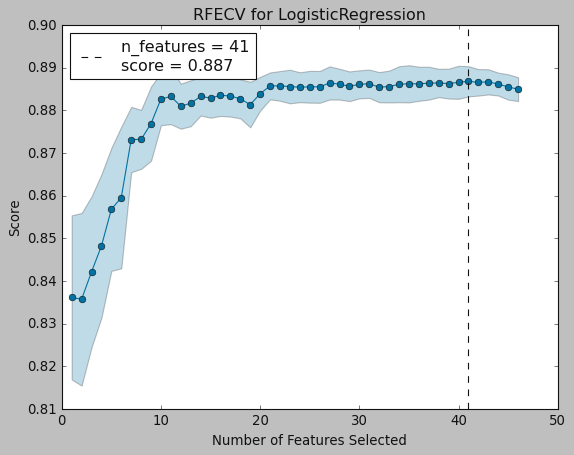

In [5]:
from yellowbrick.model_selection import rfecv
cv = StratifiedKFold(5)
visualizer = rfecv(LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000),
                   X=X_train_orig, y=Y_train_orig, cv=cv, scoring='f1_weighted')

In [6]:
mask = visualizer.get_support()
columns = X_train.columns
selected_cols = columns[mask]
X_train_orig_rfe = pd.DataFrame(visualizer.transform(X_train_orig), columns=selected_cols)
X_test_orig_rfe = pd.DataFrame(visualizer.transform(X_test_orig), columns=selected_cols)

X_train_sm_rfe = pd.DataFrame(visualizer.transform(X_train_sm), columns=selected_cols)
X_test_sm_rfe = pd.DataFrame(visualizer.transform(X_test_sm), columns=selected_cols)

X_train_smenn_rfe = pd.DataFrame(visualizer.transform(X_train_smenn), columns=selected_cols)
X_test_smenn_rfe = pd.DataFrame(visualizer.transform(X_test_smenn), columns=selected_cols)


#### Explore Base Algorithm

In [7]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # lr
    # create pipeline # Automatically selecting the number of features that resulted in the best mean score.
    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=41)
    model = LogisticRegression()
    models[ 'lr' ] = Pipeline(steps=[('s',rfe),('m' ,model)])
    # svc-linear
    rfe = RFE(estimator=SVC(kernel="linear"), n_features_to_select=41 )
    model = SVC(kernel="linear")
    models[ 'svc_linear' ] = Pipeline(steps=[( 's' ,rfe),('m' ,model)])
    # rf
    rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=41)
    model = RandomForestClassifier()
    models[ 'rf' ] = Pipeline(steps=[('s' ,rfe),('m' ,model)])
    # gb
    rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=41)
    model = GradientBoostingClassifier()
    models[ 'gb' ] = Pipeline(steps=[( 's',rfe),('m' ,model)])
    # xgb
    rfe = RFE(estimator=XGBClassifier(), n_features_to_select=41)
    model = XGBClassifier()
    models[ 'xgb' ] = Pipeline(steps=[('s',rfe),('m' ,model)])    
    # adaboost
    rfe = RFE(estimator=AdaBoostClassifier(), n_features_to_select=41)
    model = AdaBoostClassifier()
    models[ 'catb' ] = Pipeline(steps=[('s' ,rfe),('m' ,model)])
    # lgb
    rfe = RFE(estimator=LGBMClassifier(), n_features_to_select=41)
    model = LGBMClassifier()
    models[ 'lgb' ] = Pipeline(steps=[('s' ,rfe),('m' ,model)])    
    return models

In [8]:
# evaluate a given model using cross-validation
from sklearn.model_selection import RepeatedStratifiedKFold
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring= 'f1_weighted' , cv=cv, n_jobs=-1, error_score='raise')
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train_orig, Y_train_orig)
    results.append(scores)
    names.append(name)
    print( '>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>lr 0.884 (0.008)
>svc_linear 0.883 (0.008)
>rf 0.885 (0.010)
>gb 0.885 (0.010)
>xgb 0.880 (0.009)
>catb 0.880 (0.010)
>lgb 0.883 (0.010)


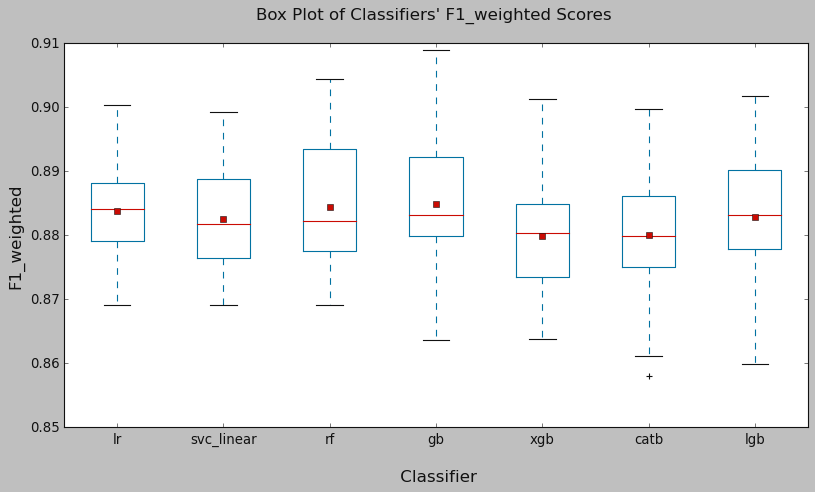

In [9]:
plt.figure(figsize=(12, 6))
plt.style.use('classic')
plt.boxplot(results, labels=names, showmeans=True)
plt.xlabel("\n Classifier", fontsize = 15)
plt.ylabel("F1_weighted", fontsize = 15)
plt.title("Box Plot of Classifiers' F1_weighted Scores \n", fontsize = 15)
plt.show()

## Model Optimization and Evaluation - Imbalanced data

In [10]:
# Grid Search Cross validation
# Find the best hyperparameters
def modelselection(model, parameters, scoring, cv, X_train, y_train):
    clf = GridSearchCV(estimator=model,
                   param_grid=parameters,
                   scoring= scoring,
                   cv=cv,
                   n_jobs=-1)
    # n_jobs refers to the number of CPU's that you want to use for excution, -1 means that use all available computing power.
    clf.fit(X_train, y_train)
    cv_results = clf.cv_results_
    best_parameters = clf.best_params_
    best_result = clf.best_score_
    print('The best parameters for classifier is', best_parameters)
    print('The best training score is %.3f:'% best_result)
    #  print(sorted(cv_results.keys()))
    return cv_results, best_parameters, best_result


In [11]:
Models = list()
resample = list()
precision = list()
recall = list()
F1score = list()
AUCROC = list()

In [12]:

# Model Measures
def test_eval(model, X_test, y_test, algo=None, sampling=None):
    # Validation set prediction
    y_pred=model.predict(X_test)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_test, y_pred))
          
    Models.append(algo)
    precision.append(precision_score(y_test,y_pred))
    recall.append(recall_score(y_test,y_pred))
    F1score.append(f1_score(y_test,y_pred))
    AUCROC.append(roc_auc_score(y_test, y_pred))
    resample.append(sampling)


#### Model_1 Logistic Regression
1. Original Unsampled Data

In [13]:
model_lr = LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000)
paras_lr = {'C' : [0.001, 0.01, 0.1, 1, 10, 100]}
scoring='f1_weighted'   # scoring parameters: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
cv = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

# Find the best hyperparameters
cv_results, best_param, best_result = modelselection(model_lr, paras_lr, scoring, cv, X_train_orig_rfe, Y_train_orig)

The best parameters for classifier is {'C': 0.1}
The best training score is 0.884:


In [14]:
final_lr = LogisticRegression(C = best_param['C'],
                            random_state=42,solver='lbfgs', max_iter=1000)
final_lr.fit( X_train_orig_rfe, Y_train_orig)
test_eval(final_lr, X_test_orig_rfe, Y_test, 'Logistic Regression', 'actual')

Confusion Matrix
[[1214   27]
 [ 110   70]] 

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1241
           1       0.72      0.39      0.51       180

    accuracy                           0.90      1421
   macro avg       0.82      0.68      0.73      1421
weighted avg       0.89      0.90      0.89      1421
 

AUC-ROC
0.6835661205121318


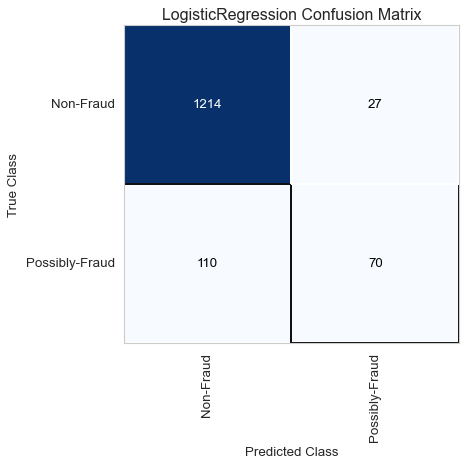

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [15]:

sns.set_style("whitegrid")
plt.figure(figsize = (6,6))
visualizer = ConfusionMatrix(
    final_lr,
    X_train_orig_rfe, Y_train_orig, X_test_orig_rfe, Y_test,
    classes=['Non-Fraud', 'Possibly-Fraud'], cmap='Blues')
visualizer.show()

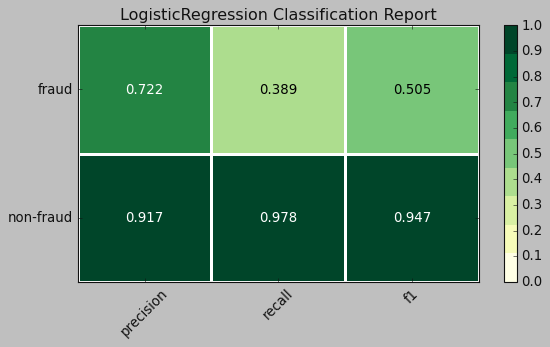

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [17]:
# Instantiate the classification model and visualizer

plt.style.use('classic') 
visualizer = ClassificationReport(final_lr, classes=['non-fraud', 'fraud'],cmap="YlGn", size=(600, 360))
visualizer.fit(X_train_orig_rfe, Y_train_orig)
visualizer.score(X_test_orig_rfe, Y_test)
visualizer.show()

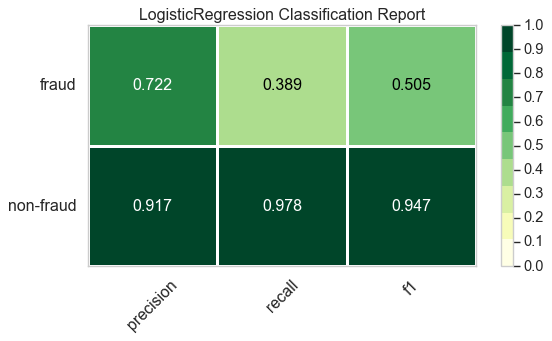

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [82]:
sns.set_style("whitegrid")
visualizer = ClassificationReport(final_lr, classes=['non-fraud', 'fraud'],cmap="YlGn", size=(600, 360))
visualizer.fit(X_train_orig_rfe, Y_train_orig)
visualizer.score(X_test_orig_rfe, Y_test)
visualizer.show()

Permutation explainer: 5684it [05:03, 18.30it/s]                          


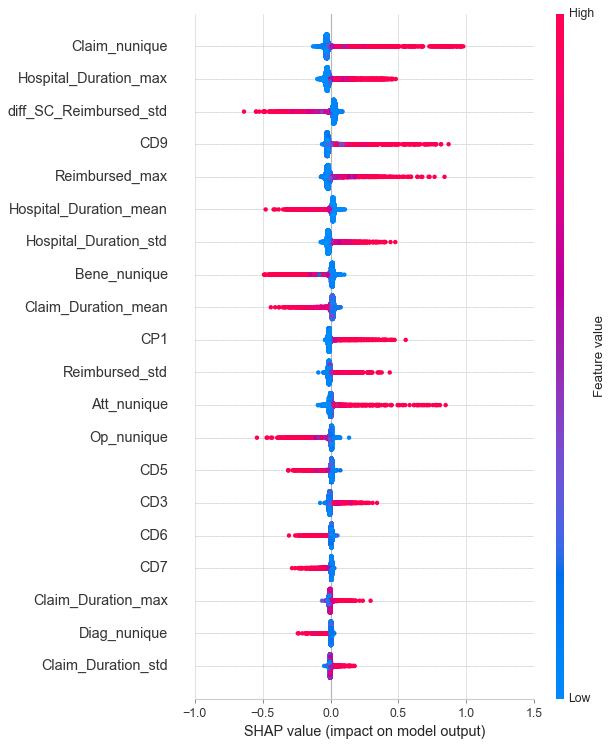

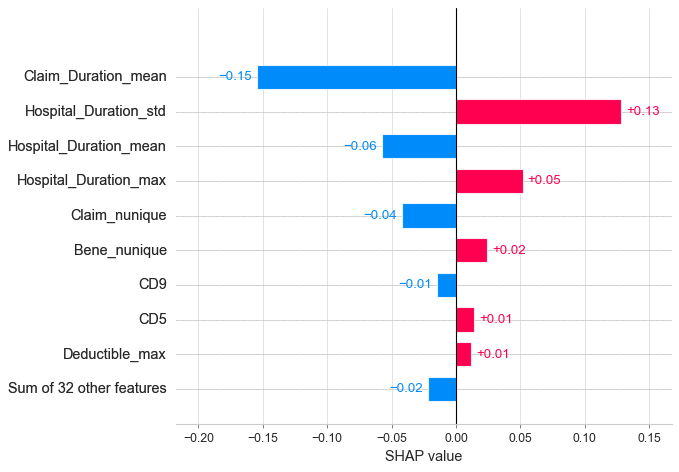

In [18]:
# https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html
#https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137
# pip install shap

sns.set_style("whitegrid")
explainer = shap.Explainer(final_lr.predict,X_test_orig_rfe,feature_names=selected_cols)
shap_values = explainer(X_train_orig_rfe)
shap.summary_plot(shap_values)
shap.plots.bar(shap_values[0])  # SHAP values for classes 0

Permutation explainer: 5684it [04:53, 18.65it/s]                          


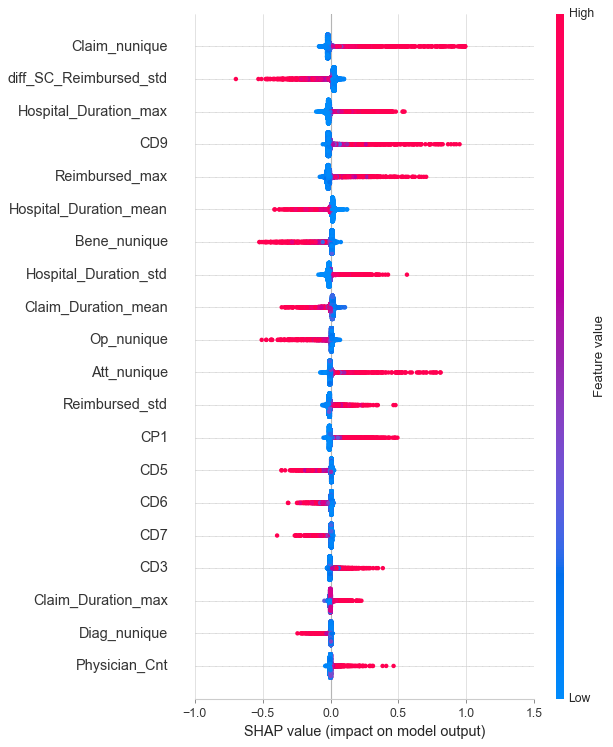

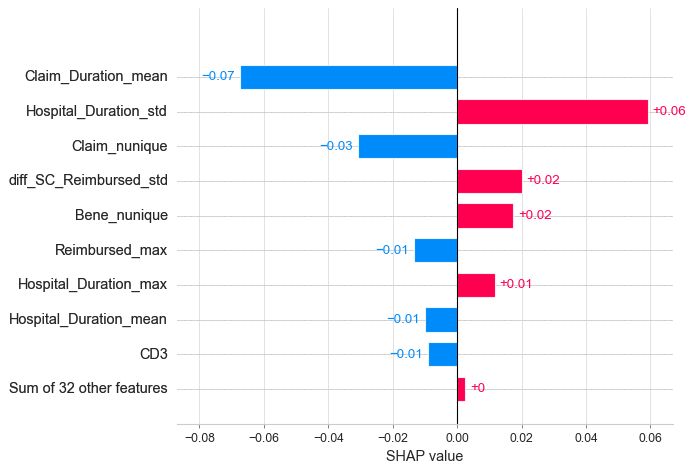

In [26]:
# https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html
#https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137
# pip install shap
sns.set_style("whitegrid")
background_X = shap.maskers.Independent(X_train_orig_rfe, max_samples=100)
explainer = shap.Explainer(final_lr.predict,background_X,feature_names=selected_cols)
shap_values = explainer(X_train_orig_rfe)
shap.summary_plot(shap_values)
shap.plots.bar(shap_values[0])


2.SMOTE Resampling data

In [19]:
# Find the best hyperparameters
cv_results, best_param, best_result = modelselection(model_lr, paras_lr, scoring, cv, X_train_sm_rfe, Y_train_sm)

The best parameters for classifier is {'C': 100}
The best training score is 0.921:


In [20]:
final_lr_sm = LogisticRegression(C = best_param['C'],
                            random_state=42,solver='lbfgs', max_iter=5000)
final_lr_sm.fit( X_train_sm_rfe, Y_train_sm)
test_eval(final_lr_sm, X_test_sm_rfe, Y_test, 'Logistic Regression', 'SMOTE')

Confusion Matrix
[[1199   42]
 [  95   85]] 

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1241
           1       0.67      0.47      0.55       180

    accuracy                           0.90      1421
   macro avg       0.80      0.72      0.75      1421
weighted avg       0.89      0.90      0.90      1421
 

AUC-ROC
0.7191892738830692


3. SMOTE +ENN Resampling

In [21]:
# Find the best hyperparameters
cv_results, best_param, best_result = modelselection(model_lr, paras_lr, scoring, cv, X_train_smenn_rfe, Y_train_smenn)

The best parameters for classifier is {'C': 100}
The best training score is 0.935:


In [22]:
final_lr_smenn = LogisticRegression(C = best_param['C'],
                            random_state=42,solver='lbfgs', max_iter=5000)
final_lr_smenn.fit( X_train_smenn_rfe, Y_train_smenn)
test_eval(final_lr_smenn, X_test_smenn_rfe, Y_test, 'Logistic Regression', 'SMOTE_ENN')

Confusion Matrix
[[1099  142]
 [  67  113]] 

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      1241
           1       0.44      0.63      0.52       180

    accuracy                           0.85      1421
   macro avg       0.69      0.76      0.72      1421
weighted avg       0.88      0.85      0.86      1421
 

AUC-ROC
0.756676963022652


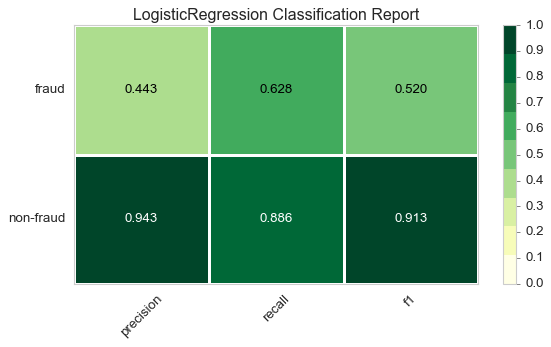

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [23]:
# Instantiate the classification model and visualizer
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(final_lr_smenn, classes=['non-fraud', 'fraud'],cmap="YlGn", size=(600, 360))
visualizer.fit(X_train_smenn_rfe, Y_train_smenn)
visualizer.score(X_test_smenn_rfe, Y_test)
visualizer.show()

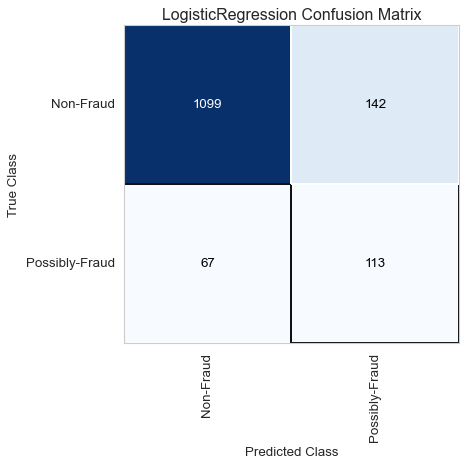

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [24]:
sns.set_style("whitegrid")
plt.figure(figsize = (6,6))
visualizer = ConfusionMatrix(
    final_lr_smenn,
    X_train_smenn_rfe, Y_train_smenn, X_test_smenn_rfe, Y_test,
    classes=['Non-Fraud', 'Possibly-Fraud'], cmap='Blues')
visualizer.show()

Permutation explainer: 7754it [06:46, 18.60it/s]                          


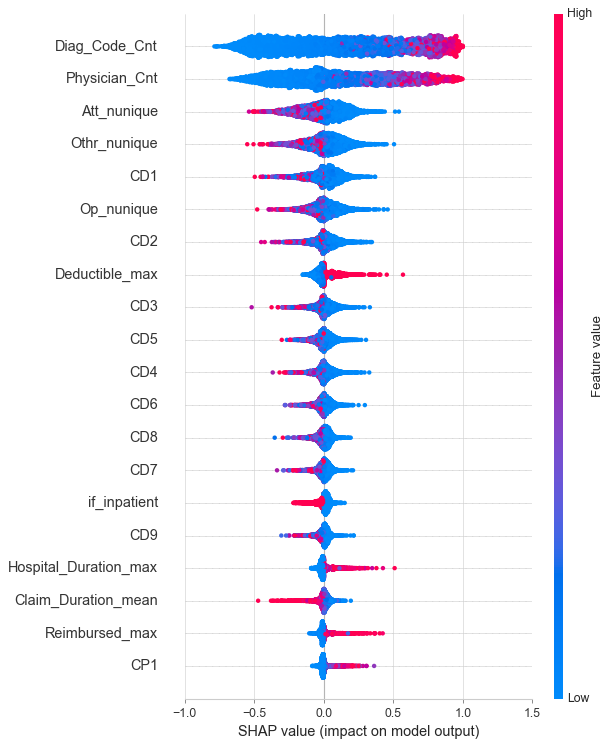

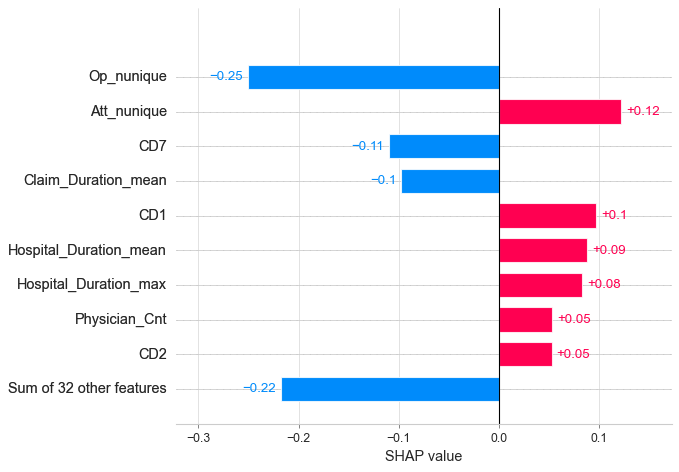

In [25]:
sns.set_style("whitegrid")
explainer = shap.Explainer(final_lr_smenn.predict,X_test_smenn_rfe,feature_names=selected_cols)
shap_values = explainer(X_train_smenn_rfe)
shap.summary_plot(shap_values)
shap.plots.bar(shap_values[0])

Permutation explainer: 7754it [06:59, 18.03it/s]                          


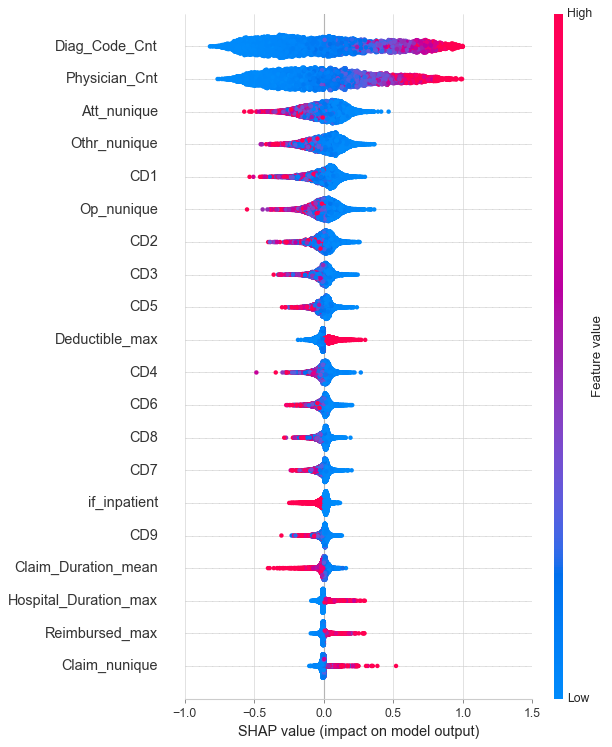

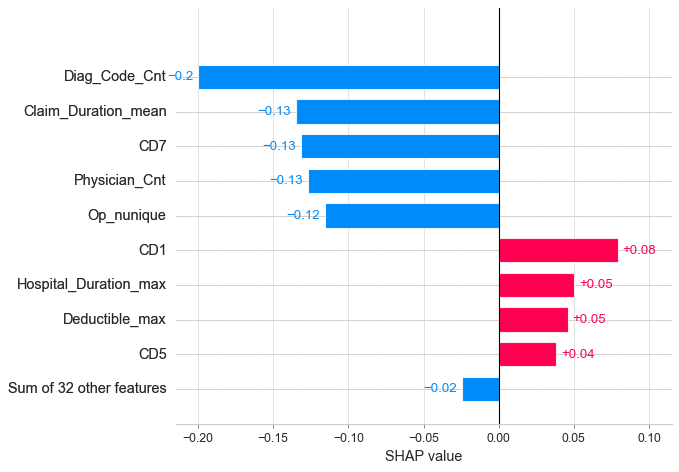

In [27]:
sns.set_style("whitegrid")
background_X_smenn = shap.maskers.Independent(X_train_smenn_rfe, max_samples=100)
explainer = shap.Explainer(final_lr_smenn.predict,background_X_smenn,feature_names=selected_cols)
shap_values = explainer(X_train_smenn_rfe)
shap.summary_plot(shap_values)
shap.plots.bar(shap_values[0])


In [28]:
# pip install yellowbrick
from yellowbrick.model_selection import LearningCurve
sizes = np.linspace(0.3, 1.0, 10)
visualizer = LearningCurve(
    final_lr_smenn, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

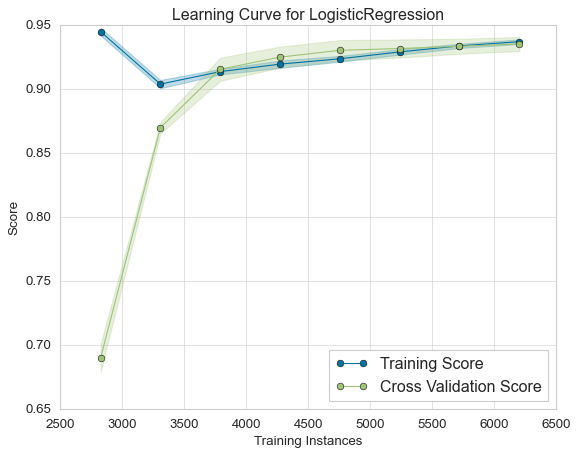

<AxesSubplot:title={'center':'Learning Curve for LogisticRegression'}, xlabel='Training Instances', ylabel='Score'>

In [29]:
# https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html
visualizer.fit(X_train_smenn_rfe, Y_train_smenn)        # Fit the data to the visualizer
visualizer.show() 

- The learning curve shows a very high variability until about 5000 instance.  Both cuvers have reached a plateau and converged together after more data, but the F1 scores are not much high, which indicates that the model has a bais problem. It's a underfitting model, and adding more training data will not help improve current model. We need to use a more complex model or come up with better features.

#### Model_2: Random Forest
1. Original Unsampled Data

In [30]:
model_rf = RandomForestClassifier(random_state=42)

paras_rf={'n_estimators':[30,50,100],
           'max_depth':[i for i in range(5,16,2)], # Minimum number of samples to consider to split a node:
           'min_samples_split':[2, 5, 10, 15, 20]} # Minimum number of samples to consider at each leaf node:

cv_results, best_param, best_result = modelselection(model_rf, paras_rf, scoring, cv, X_train_orig_rfe, Y_train_orig)



The best parameters for classifier is {'max_depth': 9, 'min_samples_split': 15, 'n_estimators': 50}
The best training score is 0.887:


In [31]:
final_rf = RandomForestClassifier(random_state=42, n_estimators= best_param['n_estimators'],
                                  max_depth= best_param['max_depth'],min_samples_split= best_param['min_samples_split'])
final_rf.fit( X_train_orig_rfe, Y_train_orig)
test_eval(final_rf, X_test_orig_rfe, Y_test, 'Random Forest', 'actual')

Confusion Matrix
[[1220   21]
 [ 115   65]] 

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      1241
           1       0.76      0.36      0.49       180

    accuracy                           0.90      1421
   macro avg       0.83      0.67      0.72      1421
weighted avg       0.89      0.90      0.89      1421
 

AUC-ROC
0.6720946369415347


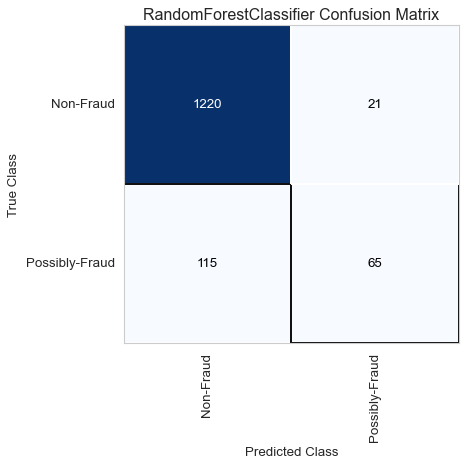

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [32]:
sns.set_style("whitegrid")
plt.figure(figsize = (6,6))
visualizer = ConfusionMatrix(
    final_rf,
    X_train_orig_rfe, Y_train_orig, X_test_orig_rfe, Y_test,
    classes=['Non-Fraud', 'Possibly-Fraud'], cmap='Blues')
visualizer.show()

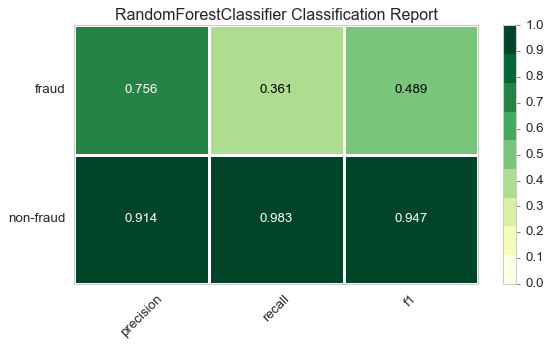

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [33]:
visualizer = ClassificationReport(final_rf, classes=['non-fraud', 'fraud'],cmap="YlGn", size=(600, 360))
visualizer.fit(X_train_orig_rfe, Y_train_orig)
visualizer.score(X_test_orig_rfe, Y_test)
visualizer.show()

Permutation explainer: 5684it [31:57,  2.95it/s]                          


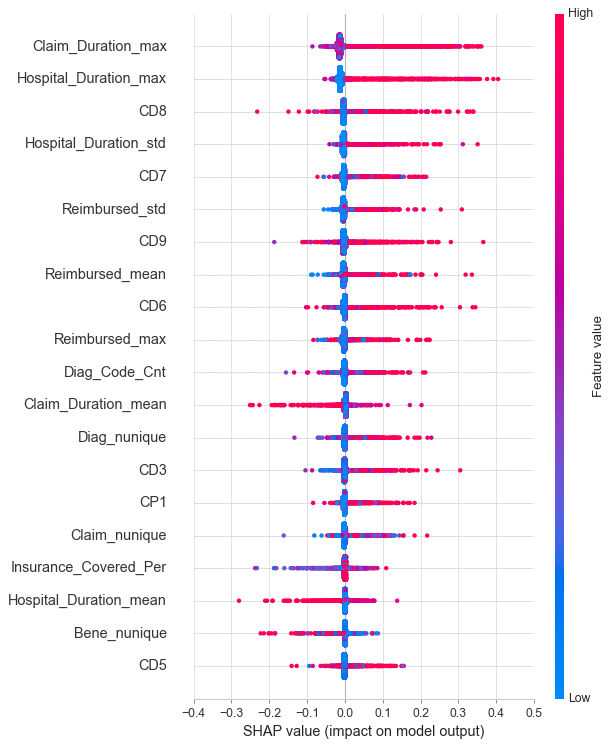

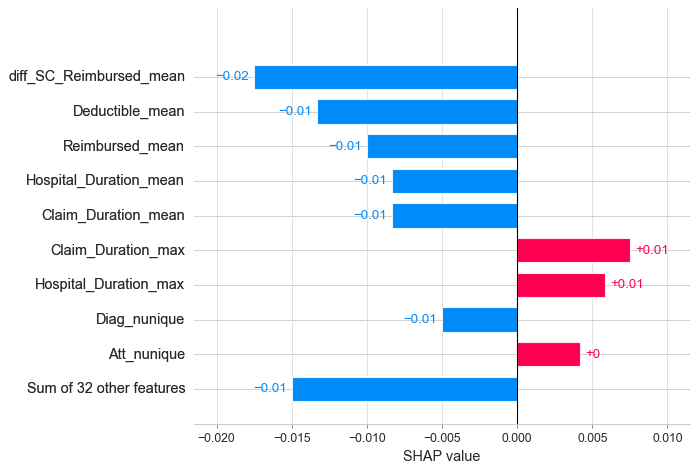

In [34]:
sns.set_style("whitegrid")
explainer = shap.Explainer(final_rf.predict,background_X,feature_names=selected_cols)
shap_values = explainer(X_train_orig_rfe)
shap.summary_plot(shap_values)
shap.plots.bar(shap_values[0])

2.SMOTE Resampling data

In [35]:
# Find the best hyperparameters
cv_results, best_param, best_result = modelselection(model_rf, paras_rf, scoring, cv, X_train_sm_rfe, Y_train_sm)

The best parameters for classifier is {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}
The best training score is 0.912:


In [36]:
final_rf_sm = RandomForestClassifier(random_state=42, n_estimators= best_param['n_estimators'],
                                  max_depth= best_param['max_depth'],min_samples_split= best_param['min_samples_split'])
final_rf_sm.fit(X_train_sm_rfe, Y_train_sm)
test_eval(final_rf_sm, X_test_sm_rfe, Y_test, 'Random Forest', 'SMOTE')

Confusion Matrix
[[1110  131]
 [  71  109]] 

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.89      0.92      1241
           1       0.45      0.61      0.52       180

    accuracy                           0.86      1421
   macro avg       0.70      0.75      0.72      1421
weighted avg       0.88      0.86      0.87      1421
 

AUC-ROC
0.7499977616617424


3. SMOTE +ENN Resampling

In [37]:
# Find the best hyperparameters
cv_results, best_param, best_result = modelselection(model_rf, paras_rf, scoring, cv, X_train_smenn_rfe, Y_train_smenn)

The best parameters for classifier is {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 50}
The best training score is 0.942:


In [38]:
final_rf_smenn = RandomForestClassifier(random_state=42, n_estimators= best_param['n_estimators'],
                                  max_depth= best_param['max_depth'],min_samples_split= best_param['min_samples_split'])
final_rf_smenn.fit(X_train_smenn_rfe, Y_train_smenn)
test_eval(final_rf_smenn, X_test_smenn_rfe, Y_test, 'Random Forest', 'SMOTE_ENN')

Confusion Matrix
[[982 259]
 [ 45 135]] 

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.79      0.87      1241
           1       0.34      0.75      0.47       180

    accuracy                           0.79      1421
   macro avg       0.65      0.77      0.67      1421
weighted avg       0.88      0.79      0.82      1421
 

AUC-ROC
0.770648670427075


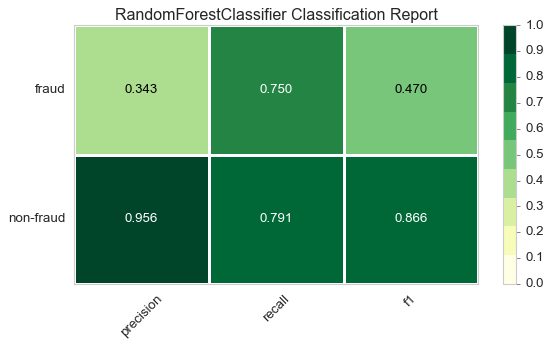

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [39]:
# Instantiate the classification model and visualizer

visualizer = ClassificationReport(final_rf_smenn, classes=['non-fraud', 'fraud'],cmap="YlGn", size=(600, 360))
visualizer.fit(X_train_smenn_rfe, Y_train_smenn)
visualizer.score(X_test_smenn_rfe, Y_test)
visualizer.show()

Permutation explainer: 7754it [47:03,  2.74it/s]                          


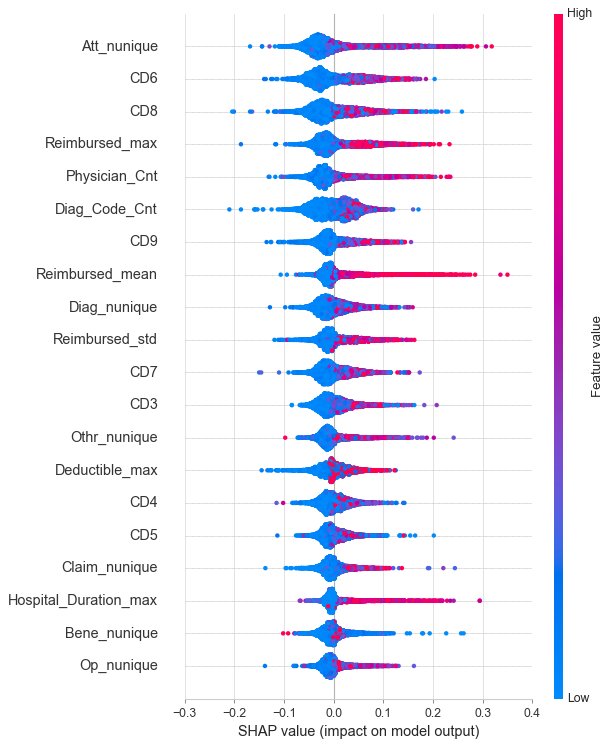

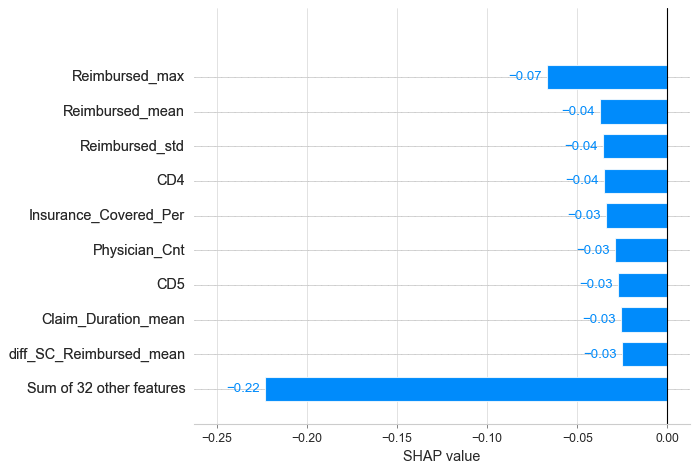

In [40]:
sns.set_style("whitegrid")

explainer = shap.Explainer(final_rf_smenn.predict,background_X_smenn,feature_names=selected_cols)
shap_values = explainer(X_train_smenn_rfe)
shap.summary_plot(shap_values)
shap.plots.bar(shap_values[0])

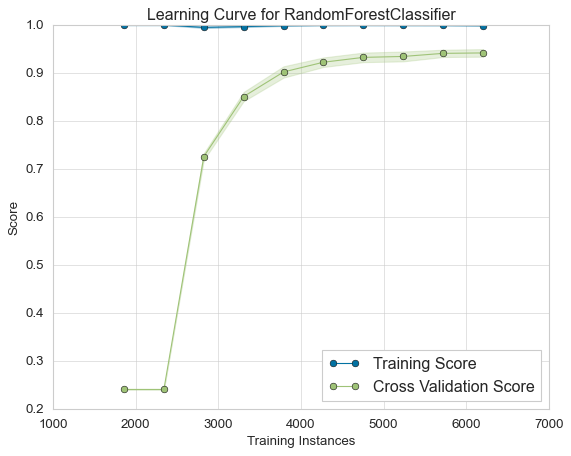

<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [41]:
# https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html
visualizer = LearningCurve(
    final_rf_smenn, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4)
visualizer.fit(X_train_smenn_rfe, Y_train_smenn)        # Fit the data to the visualizer
visualizer.show() 

#### Model_3: Gradient Boosting 
1. Original Unsampled Data

In [46]:
model_gb = GradientBoostingClassifier(learning_rate=1.0, random_state=42)

# declare parameters for hyperparameter tuning
paras_gb = {'n_estimators':[120,140,160],'max_depth':range(8,12,1),  'min_samples_leaf':range(20,61,10)}

cv_results, best_param, best_result = modelselection(model_gb, paras_gb, scoring, cv, X_train_orig_rfe, Y_train_orig)

The best parameters for classifier is {'max_depth': 11, 'min_samples_leaf': 40, 'n_estimators': 140}
The best training score is 0.879:


In [48]:
final_gb = GradientBoostingClassifier(learning_rate=1.0,random_state=42, n_estimators= best_param['n_estimators'],
                                  max_depth= best_param['max_depth'], min_samples_leaf= best_param['min_samples_leaf'])
final_gb.fit(X_train_orig_rfe, Y_train_orig)
test_eval(final_gb, X_test_orig_rfe, Y_test, 'Gradient Boosting', 'actual')

Confusion Matrix
[[1191   50]
 [ 111   69]] 

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      1241
           1       0.58      0.38      0.46       180

    accuracy                           0.89      1421
   macro avg       0.75      0.67      0.70      1421
weighted avg       0.87      0.89      0.88      1421
 

AUC-ROC
0.6715216223475691


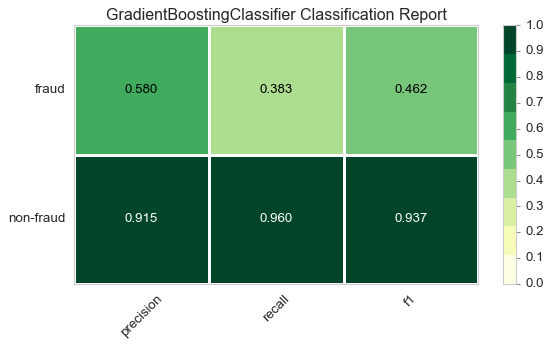

<AxesSubplot:title={'center':'GradientBoostingClassifier Classification Report'}>

In [49]:
visualizer = ClassificationReport(final_gb, classes=['non-fraud', 'fraud'],cmap="YlGn", size=(600, 360))
visualizer.fit(X_train_orig_rfe, Y_train_orig)
visualizer.score(X_test_orig_rfe, Y_test)
visualizer.show()

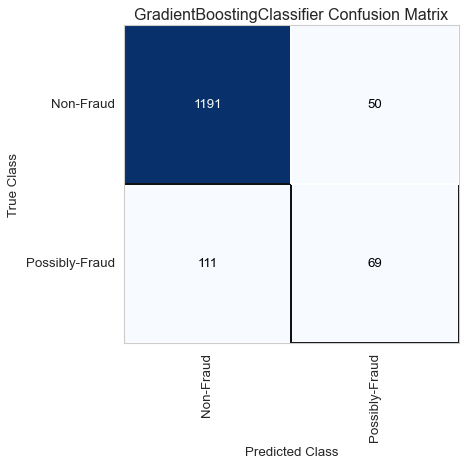

<AxesSubplot:title={'center':'GradientBoostingClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [50]:
sns.set_style("whitegrid")
plt.figure(figsize = (6,6))
visualizer = ConfusionMatrix(
    final_gb,
    X_train_orig_rfe, Y_train_orig, X_test_orig_rfe, Y_test,
    classes=['Non-Fraud', 'Possibly-Fraud'], cmap='Blues')
visualizer.show()

Permutation explainer: 5684it [30:54,  3.05it/s]                          


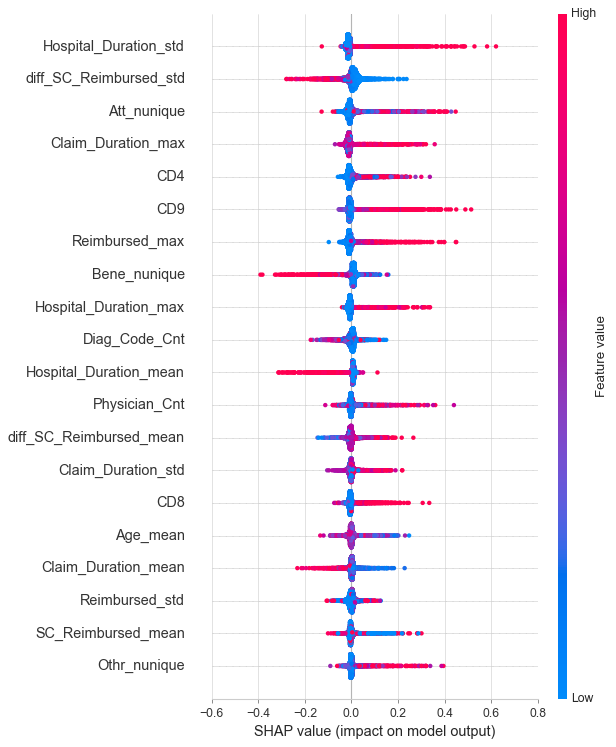

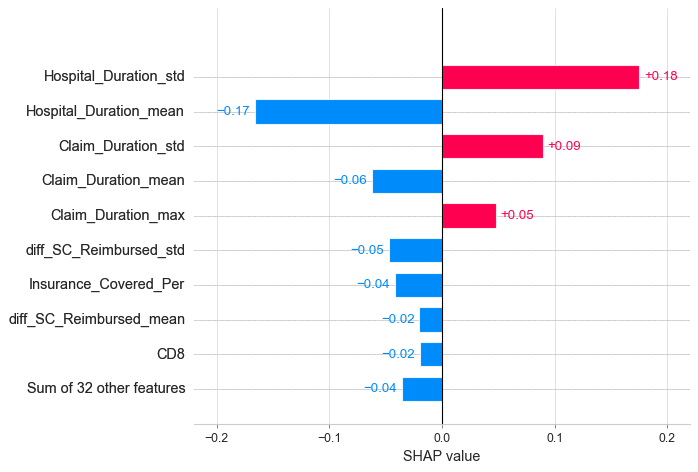

In [51]:
explainer = shap.Explainer(final_gb.predict,background_X,feature_names=selected_cols)
shap_values = explainer(X_train_orig_rfe)
shap.summary_plot(shap_values)
shap.plots.bar(shap_values[0])

2. SMOTE +Resampling

In [52]:
cv_results, best_param, best_result = modelselection(model_gb, paras_gb, scoring, cv, X_train_sm_rfe, Y_train_sm)

The best parameters for classifier is {'max_depth': 9, 'min_samples_leaf': 30, 'n_estimators': 160}
The best training score is 0.942:


In [54]:
final_gb_sm = GradientBoostingClassifier(learning_rate=1.0,random_state=42, n_estimators= best_param['n_estimators'],
                                          max_depth= best_param['max_depth'], min_samples_leaf= best_param['min_samples_leaf'])
final_gb_sm.fit(X_train_sm_rfe, Y_train_sm)
test_eval(final_gb_sm, X_test_sm_rfe, Y_test, 'Gradient Boosting', 'SMOTE')

Confusion Matrix
[[1147   94]
 [  95   85]] 

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1241
           1       0.47      0.47      0.47       180

    accuracy                           0.87      1421
   macro avg       0.70      0.70      0.70      1421
weighted avg       0.87      0.87      0.87      1421
 

AUC-ROC
0.6982384277912078


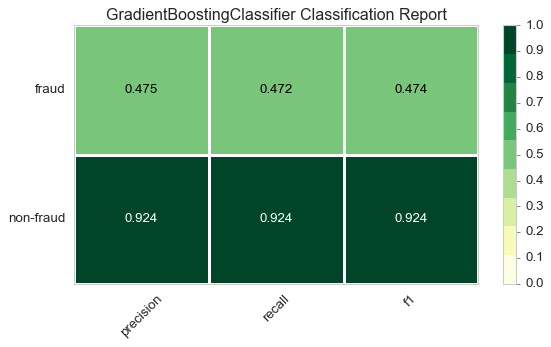

<AxesSubplot:title={'center':'GradientBoostingClassifier Classification Report'}>

In [55]:
visualizer = ClassificationReport(final_gb_sm, classes=['non-fraud', 'fraud'],cmap="YlGn", size=(600, 360))
visualizer.fit(X_train_sm_rfe, Y_train_sm)
visualizer.score(X_test_sm_rfe, Y_test)
visualizer.show()

3. SMOTE +ENN Resampling

In [56]:

cv_results, best_param, best_result = modelselection(model_gb, paras_gb, scoring, cv, X_train_smenn_rfe, Y_train_smenn)

The best parameters for classifier is {'max_depth': 10, 'min_samples_leaf': 50, 'n_estimators': 120}
The best training score is 0.964:


In [57]:
final_gb_smenn = GradientBoostingClassifier(learning_rate=1.0,random_state=42, n_estimators= best_param['n_estimators'],
                                  max_depth= best_param['max_depth'], min_samples_leaf= best_param['min_samples_leaf'])
final_gb_smenn.fit(X_train_smenn_rfe, Y_train_smenn)
test_eval(final_gb_smenn, X_test_smenn_rfe, Y_test, 'Gradient Boosting', 'SMOTE_ENN')

Confusion Matrix
[[1045  196]
 [  60  120]] 

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      1241
           1       0.38      0.67      0.48       180

    accuracy                           0.82      1421
   macro avg       0.66      0.75      0.69      1421
weighted avg       0.87      0.82      0.84      1421
 

AUC-ROC
0.7543647596024711


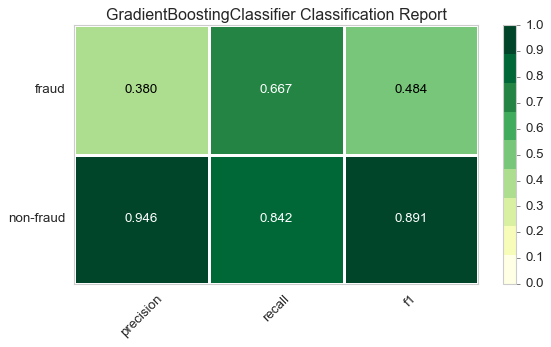

<AxesSubplot:title={'center':'GradientBoostingClassifier Classification Report'}>

In [58]:
visualizer = ClassificationReport(final_gb_smenn, classes=['non-fraud', 'fraud'],cmap="YlGn", size=(600, 360))
visualizer.fit(X_train_smenn_rfe, Y_train_smenn)
visualizer.score(X_test_smenn_rfe, Y_test)
visualizer.show()

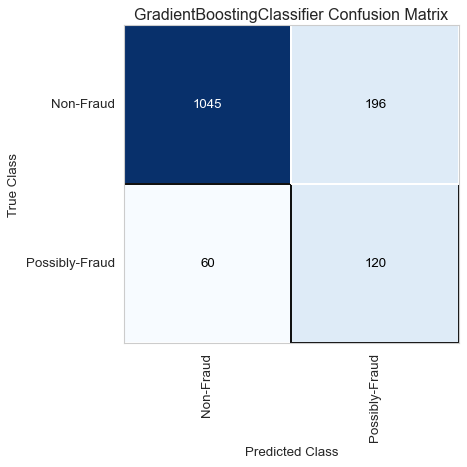

<AxesSubplot:title={'center':'GradientBoostingClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [60]:
plt.figure(figsize = (6,6))
visualizer = ConfusionMatrix(
    final_gb_smenn,
    X_train_smenn_rfe, Y_train_smenn, X_test_smenn_rfe, Y_test,
    classes=['Non-Fraud', 'Possibly-Fraud'], cmap='Blues')
visualizer.show()

Permutation explainer: 7754it [34:27,  3.73it/s]                          


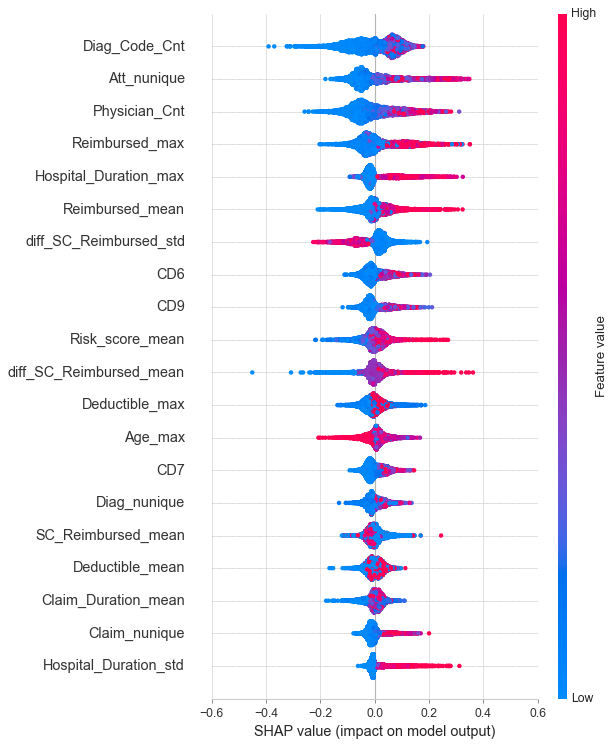

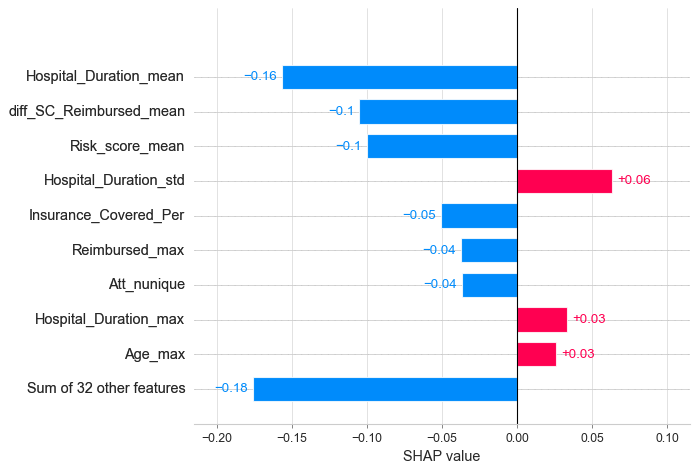

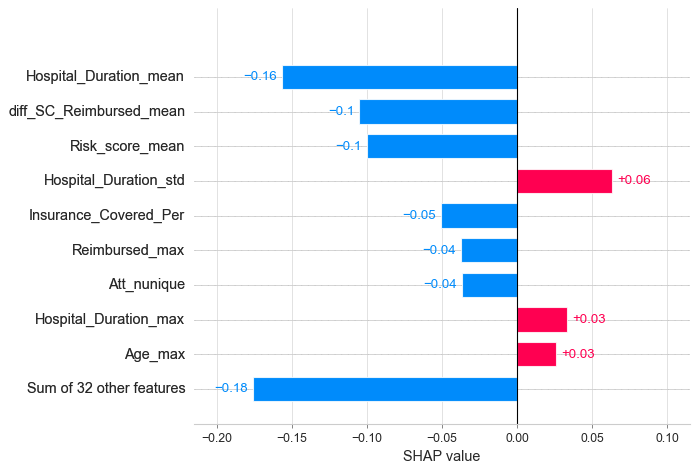

In [61]:
explainer = shap.Explainer(final_gb_smenn.predict,background_X_smenn,feature_names=selected_cols)
shap_values = explainer(X_train_smenn_rfe)
shap.summary_plot(shap_values)
shap.plots.bar(shap_values[0])
shap.plots.bar(shap_values[0])

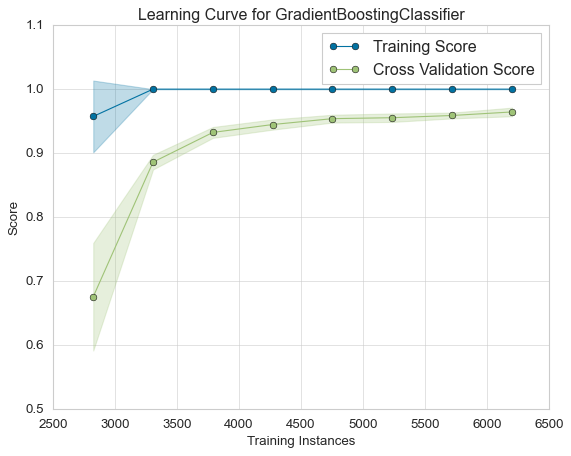

<AxesSubplot:title={'center':'Learning Curve for GradientBoostingClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [62]:
visualizer = LearningCurve(
    final_gb_smenn, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4)
visualizer.fit(X_train_smenn_rfe, Y_train_smenn)        # Fit the data to the visualizer
visualizer.show() 

# Model Comparision

In [64]:
clf_eval_df = pd.DataFrame({'model':Models,
                            'resample':resample,
                            'precision':precision,
                            'recall':recall,
                            'f1-score':F1score,
                            'AUC-ROC':AUCROC})
clf_eval_df

,model,resample,precision,recall,f1-score,AUC-ROC
0,Logistic Regression,actual,0.721649,0.388889,0.505415,0.683566
1,Logistic Regression,SMOTE,0.669291,0.472222,0.553746,0.719189
2,Logistic Regression,SMOTE_ENN,0.443137,0.627778,0.519540,0.756677
3,Random Forest,actual,0.755814,0.361111,0.488722,0.672095
4,Random Forest,SMOTE,0.454167,0.605556,0.519048,0.749998
5,Random Forest,SMOTE_ENN,0.342640,0.750000,0.470383,0.770649
6,Gradient Boosting,actual,0.579832,0.383333,0.461538,0.671522
7,Gradient Boosting,SMOTE,0.474860,0.472222,0.473538,0.698238
8,Gradient Boosting,SMOTE_ENN,0.379747,0.666667,0.483871,0.754365


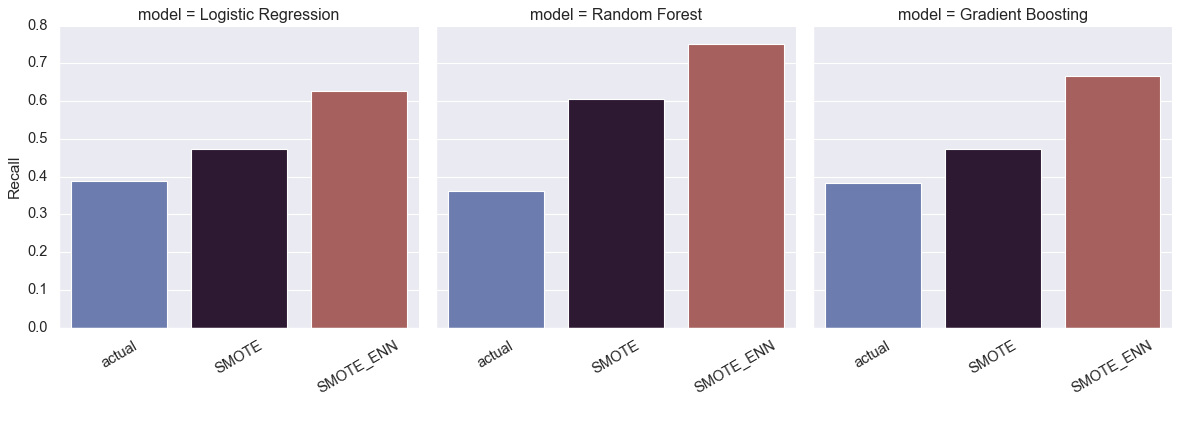

In [65]:
sns.set(font_scale=1.2)
#sns.palplot(sns.color_palette())
g = sns.FacetGrid(clf_eval_df, col="model", height=5)
g.map(sns.barplot, "resample", "recall", palette='twilight', order=["actual", "SMOTE", "SMOTE_ENN"])
g.set_xticklabels(rotation=30)
g.set_xlabels(' ', fontsize=14)
g.set_ylabels('Recall', fontsize=14)

#### Model_4: Support Vector Machines (SVM)
1. Original Unsampled Data

In [66]:
model_svm = SVC() 

# declare parameters for hyperparameter tuning
paras_svm = [ {'C':[1,10], 'kernel':['linear']}
              # {'C':[1, 10, 100], 'kernel':['rbf'], 'gamma':[0.001, 0.01, 0.1]},
              # {'C':[1, 10, 100], 'kernel':['poly'], 'degree': [2,3]} 
              ]

cv_results, best_param, best_result = modelselection(model_svm, paras_svm, scoring, cv, X_train_orig_rfe, Y_train_orig)

The best parameters for classifier is {'C': 1, 'kernel': 'linear'}
The best training score is 0.884:


In [67]:
final_svm = SVC(random_state=42, C= best_param['C'],
                                  kernel= best_param['kernel'])
final_svm.fit(X_train_orig_rfe, Y_train_orig)
test_eval(final_svm, X_test_orig_rfe, Y_test, 'Support Vector Machines', 'actual')

Confusion Matrix
[[1217   24]
 [ 111   69]] 

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1241
           1       0.74      0.38      0.51       180

    accuracy                           0.90      1421
   macro avg       0.83      0.68      0.73      1421
weighted avg       0.89      0.90      0.89      1421
 

AUC-ROC
0.6819970453934999


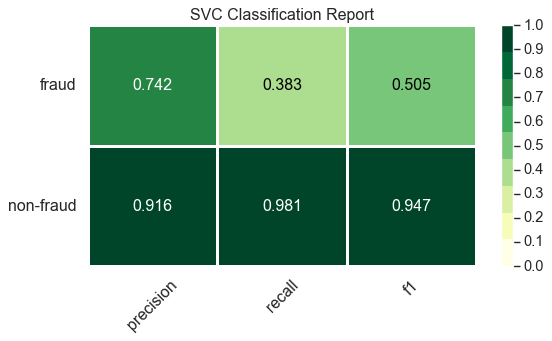

<AxesSubplot:title={'center':'SVC Classification Report'}>

In [68]:
visualizer = ClassificationReport(final_svm, classes=['non-fraud', 'fraud'],cmap="YlGn", size=(600, 360))
visualizer.fit(X_train_orig_rfe, Y_train_orig)
visualizer.score(X_test_orig_rfe, Y_test)
visualizer.show()

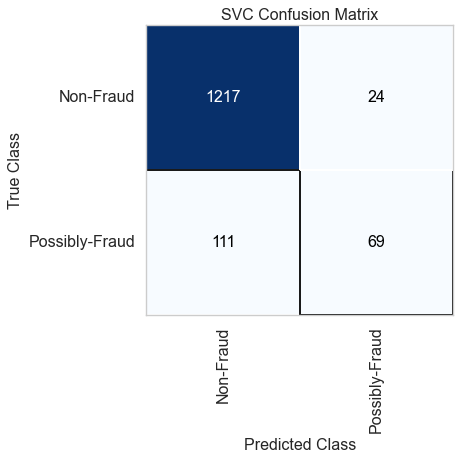

<AxesSubplot:title={'center':'SVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [69]:
sns.set_style("whitegrid")
plt.figure(figsize = (6,6))
visualizer = ConfusionMatrix(
    final_svm,
    X_train_orig_rfe, Y_train_orig, X_test_orig_rfe, Y_test,
    classes=['Non-Fraud', 'Possibly-Fraud'], cmap='Blues')
visualizer.show()

Permutation explainer: 5684it [15:30:05,  9.82s/it]                                  


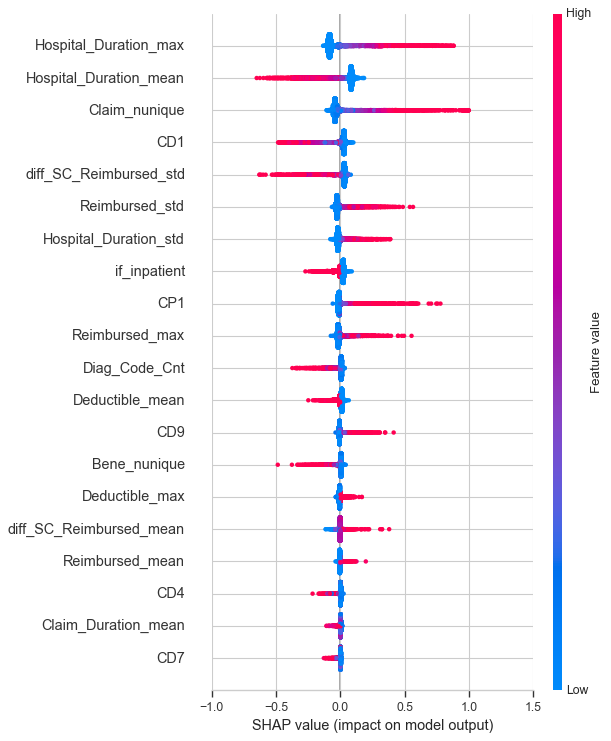

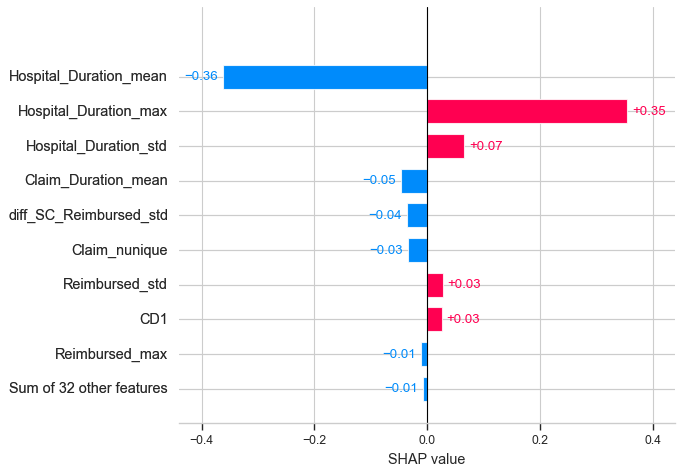

In [70]:
explainer = shap.Explainer(final_svm.predict,background_X,feature_names=selected_cols)
shap_values = explainer(X_train_orig_rfe)
shap.summary_plot(shap_values)
shap.plots.bar(shap_values[0])

2. SMOTE +Resampling

In [71]:
cv_results, best_param, best_result = modelselection(model_svm, paras_svm, scoring, cv, X_train_sm_rfe, Y_train_sm)
final_svm_sm = SVC(random_state=42, C= best_param['C'],
                                 kernel= best_param['kernel'])


The best parameters for classifier is {'C': 10, 'kernel': 'linear'}
The best training score is 0.907:


In [72]:
final_svm_sm.fit(X_train_sm_rfe, Y_train_sm)
test_eval(final_svm_sm, X_test_sm_rfe, Y_test, 'Support Vector Machines', 'SMOTE')

Confusion Matrix
[[1199   42]
 [  92   88]] 

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1241
           1       0.68      0.49      0.57       180

    accuracy                           0.91      1421
   macro avg       0.80      0.73      0.76      1421
weighted avg       0.90      0.91      0.90      1421
 

AUC-ROC
0.7275226072164025


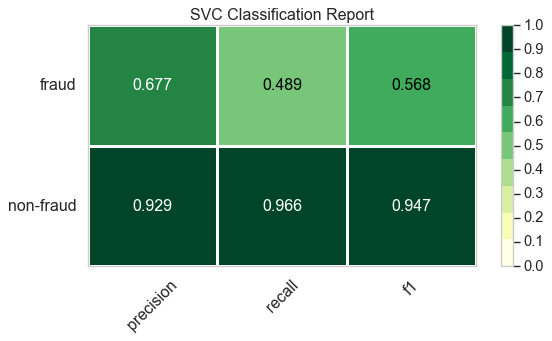

<AxesSubplot:title={'center':'SVC Classification Report'}>

In [73]:
visualizer = ClassificationReport(final_svm_sm, classes=['non-fraud', 'fraud'],cmap="YlGn", size=(600, 360))
visualizer.fit(X_train_sm_rfe, Y_train_sm)
visualizer.score(X_test_sm_rfe, Y_test)
visualizer.show()

3. SMOTE +ENN Resampling

In [74]:

cv_results, best_param, best_result = modelselection(model_svm, paras_svm, scoring, cv, X_train_smenn_rfe, Y_train_smenn)

The best parameters for classifier is {'C': 10, 'kernel': 'linear'}
The best training score is 0.928:


In [75]:
final_svm_enn = SVC(random_state=42, C= best_param['C'],
                                  kernel= best_param['kernel'])
final_svm_enn.fit(X_train_smenn_rfe, Y_train_smenn)
test_eval(final_svm_enn, X_test_smenn_rfe, Y_test, 'Support Vector Machines', 'SMOTE_ENN')

Confusion Matrix
[[1086  155]
 [  64  116]] 

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1241
           1       0.43      0.64      0.51       180

    accuracy                           0.85      1421
   macro avg       0.69      0.76      0.71      1421
weighted avg       0.88      0.85      0.86      1421
 

AUC-ROC
0.7597725848330199


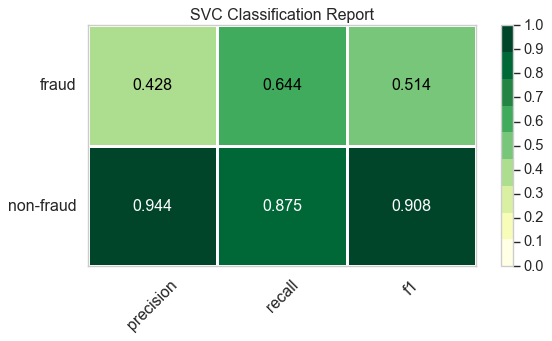

<AxesSubplot:title={'center':'SVC Classification Report'}>

In [76]:
visualizer = ClassificationReport(final_svm_enn, classes=['non-fraud', 'fraud'],cmap="YlGn", size=(600, 360))
visualizer.fit(X_train_smenn_rfe, Y_train_smenn)
visualizer.score(X_test_smenn_rfe, Y_test)
visualizer.show()

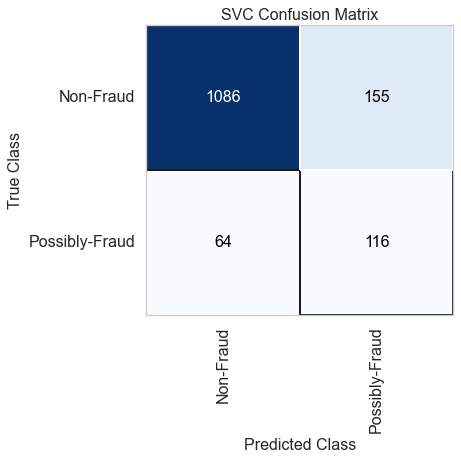

<AxesSubplot:title={'center':'SVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [77]:
plt.figure(figsize = (6,6))
visualizer = ConfusionMatrix(
    final_svm_enn,
    X_train_smenn_rfe, Y_train_smenn, X_test_smenn_rfe, Y_test,
    classes=['Non-Fraud', 'Possibly-Fraud'], cmap='Blues')
visualizer.show()

Permutation explainer: 7754it [20:33:49,  9.55s/it]                                 


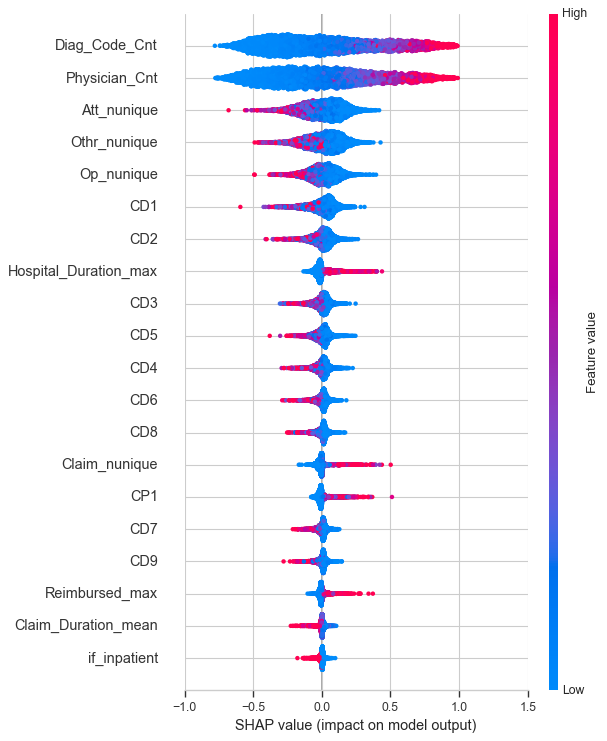

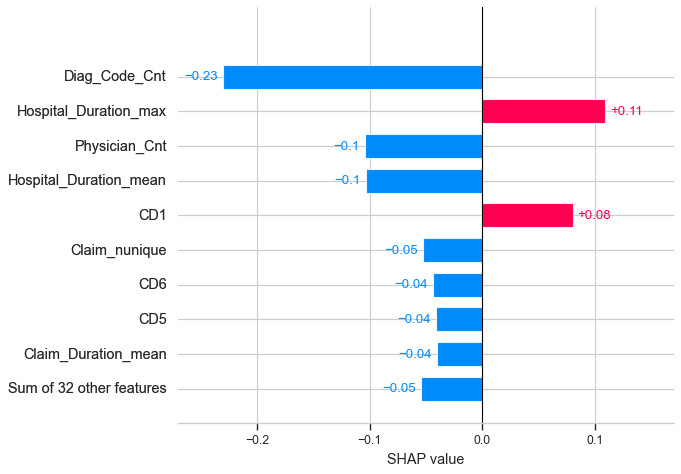

In [78]:
## Using SHAP values to explain feature inportance

explainer = shap.Explainer(final_svm_enn.predict,background_X_smenn,feature_names=selected_cols)
shap_values = explainer(X_train_smenn_rfe)
shap.summary_plot(shap_values)
shap.plots.bar(shap_values[0])

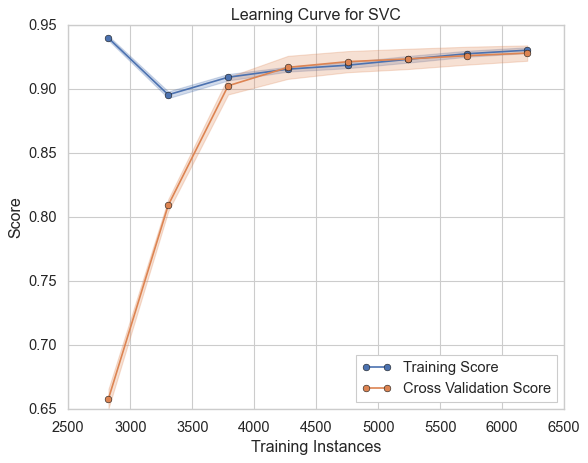

<AxesSubplot:title={'center':'Learning Curve for SVC'}, xlabel='Training Instances', ylabel='Score'>

In [79]:
# https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html
visualizer = LearningCurve(
    final_svm_enn, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4)
visualizer.fit(X_train_smenn_rfe, Y_train_smenn)        # Fit the data to the visualizer
visualizer.show() 

# Model Comparision

In [80]:
clf_eval_df2 = pd.DataFrame({'model':Models,
                            'resample':resample,
                            'precision':precision,
                            'recall':recall,
                            'f1-score':F1score,
                            'AUC-ROC':AUCROC})
clf_eval_df2

,model,resample,precision,recall,f1-score,AUC-ROC
0,Logistic Regression,actual,0.721649,0.388889,0.505415,0.683566
1,Logistic Regression,SMOTE,0.669291,0.472222,0.553746,0.719189
2,Logistic Regression,SMOTE_ENN,0.443137,0.627778,0.519540,0.756677
3,Random Forest,actual,0.755814,0.361111,0.488722,0.672095
4,Random Forest,SMOTE,0.454167,0.605556,0.519048,0.749998
5,Random Forest,SMOTE_ENN,0.342640,0.750000,0.470383,0.770649
6,Gradient Boosting,actual,0.579832,0.383333,0.461538,0.671522
7,Gradient Boosting,SMOTE,0.474860,0.472222,0.473538,0.698238
8,Gradient Boosting,SMOTE_ENN,0.379747,0.666667,0.483871,0.754365
9,Support Vector Machines,actual,0.741935,0.383333,0.505495,0.681997


In [ ]:
#clf_eval_df['model']=['Logistic Regression','Logistic Regression','Logistic Regression','Random Forest',
#                      'Random Forest','Random Forest', 'Support Vector Machines','Support Vector Machines',
#                     'Support Vector Machines']

In [ ]:
clf_eval_df2

In [ ]:
clf_eval_df2 = clf_eval_df2.replace("SMOTE +ENN","SMOTE_ENN")

In [ ]:
clf_eval_df2

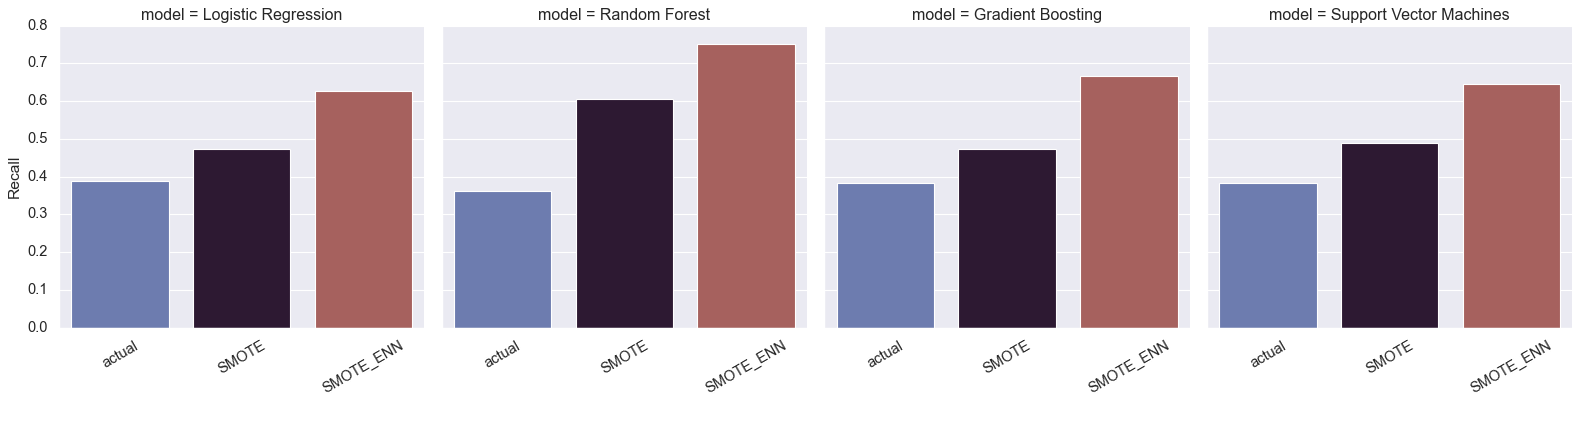

In [81]:
sns.set(font_scale=1.2)
#sns.palplot(sns.color_palette())
g = sns.FacetGrid(clf_eval_df2, col="model", height=5)
g.map(sns.barplot, "resample", "recall", palette='twilight', order=["actual", "SMOTE", "SMOTE_ENN"])
g.set_xticklabels(rotation=30)
g.set_xlabels(' ', fontsize=14)
g.set_ylabels('Recall', fontsize=14)